In [1]:

# This is the main torch package
import torch 
#Computer vision specific package              
import torchvision
#There are a bunch of standard datasets in torchvision. 
import torchvision.datasets as datasets

# -------------------------------------------------
# Pytorch Lightning 
# -------------------------------------------------

#import pytorch_lightning as pl
# this gives us the hooks to connect to TensorBoard
#import pytorch_lightning.loggers as pl_loggers


# Librosa for processing datasets

import librosa as lb

# Import Google Drive Access
from google.colab import files

import os
import pickle
import gzip

import numpy as np


# Data Helper Functions



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def song_to_cqt(song_path):
  song, sampling_rate = lb.load(song_path)
  C= lb.cqt(song,sampling_rate)
  desire_spect_len = 2580
  # if spectral respresentation too long, crop it, otherwise, zero-pad
  if C.shape[1] >= desire_spect_len:
    C = C[:,0:desire_spect_len]
  else:
    C = np.pad(C,((0,0),(0,desire_spect_len-C.shape[1])), 'constant')
  return C

def create_feature_matrix(song_folder_path):
  reference_feature_matrix = {}
  cover_feature_matrix = {}
  i = 0
  for songname in os.listdir(song_folder_path):
    if songname!='.DS_Store':
      song_folder = song_folder_path + '/' + songname
      for song in os.listdir(song_folder):
        song_path = song_folder + '/' + song
        if song.find('Cover') != -1:
          cover_feature_matrix[song] = song_to_cqt(song_path)
        else: 
          ref_song = song[0:song.find('Original')]
          reference_feature_matrix[ref_song] = song_to_cqt(song_path)
    i = i + 1
    print(i)
  return cover_feature_matrix, reference_feature_matrix

def save_feature_matrix(song_folder_path, save_path):
  cover_songs, reference_songs = create_feature_matrix(song_folder_path)
  print("")
  print('Saving Feature Matrix')
  r_outfile = open(save_path + 'references','wb')
  pickle.dump(reference_songs, r_outfile)
  r_outfile.close()
  c_outfile = open(save_path + 'covers','wb')
  pickle.dump(cover_songs, c_outfile)
  c_outfile.close()


      

# Load Training Data

In [ ]:
### Run this Cell only once ###
# Saves CQT of covers and reference songs to Google Drive 
train_set_path = '/content/drive/MyDrive/Deep Learning Final Project/secondhandsongs'
train_store_path = '/content/drive/MyDrive/Deep Learning Final Project/train_data/'

save_feature_matrix(train_set_path, train_store_path)


print('Load Completed')


In [ ]:
### Run Every Time Notebook Resets ###


# Load Cover Song and Refernce Song CQT representation from Google Drive

covers_path = '/content/drive/MyDrive/Deep Learning Final Project/train_data/covers'
references_path = '/content/drive/MyDrive/Deep Learning Final Project/train_data/references'

infile = open(covers_path,'rb')
cover_songs = pickle.load(infile)
infile.close()

infile = open(references_path,'rb')
reference_songs = pickle.load(infile)
infile.close()


# Convert Feature Matrix to training data (tuples of song pairs) and labels (0 if cover, 1 if not cover)

train_data = []
train_labels = np.array([])
for reference_song in reference_songs:
  for cover_song in cover_songs:
      label = int(cover_song.find(reference_song) == -1)
      train_labels = np.append(train_labels,label)
      song_tuple = (torch.from_numpy(cover_songs[cover_song]), torch.from_numpy(reference_songs[reference_song]))
      train_data.append(song_tuple)


In [ ]:
print(reference_songs)

{'Four Brothers': array([[ 0.03356609+2.74210352e-03j,  0.04855265-3.07938705e-02j,
        -0.02272638-9.06286152e-02j, ..., -0.01397331-2.96064168e-02j,
         0.00549223-3.00278791e-03j, -0.01916768-3.73059013e-02j],
       [ 0.16591703-2.01931189e-04j,  0.05240116-1.57688830e-01j,
        -0.13331603-9.92636912e-02j, ...,  0.08549141-8.99310585e-02j,
        -0.05908271-1.12205952e-01j, -0.12499626+1.64180011e-02j],
       [-0.02845205-3.82821924e-03j, -0.06708889-1.56345825e-02j,
        -0.10259157+5.60544595e-02j, ..., -0.02094365-8.68822767e-02j,
        -0.10448399-4.86960610e-02j, -0.1196942 +6.29917934e-02j],
       ...,
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j, ..., -0.02131794-3.00791038e-02j,
         0.0220953 +2.90151421e-03j,  0.00865087+1.24526209e-02j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j, ..., -0.02755425-1.78192512e-02j,
         0.038252

# Custom PyTorch Dataset for Songs

In [ ]:
from torch.utils.data import DataLoader,Dataset
import random

class CoverSongDataset(Dataset):
    
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self,index):
        #we need to make sure approx 50% of song pairs are cover/reference pairs
        should_be_cover = random.randint(0,1) 

        if should_be_cover:
          while True:
            rand_ind = random.randint(0,len(self.labels)-1)
            if self.labels[rand_ind] == 0:
              song0,song1 = self.data[rand_ind]
              lab = self.labels[rand_ind]
              break
        else: 
          while True:
            rand_ind = random.randint(0,len(self.labels)-1)
            if self.labels[rand_ind] == 1:
              song0,song1 = self.data[rand_ind]
              lab = self.labels[rand_ind]
              break

        return song0, song1 , torch.from_numpy(np.array([lab],dtype=np.float32))
    
    def __len__(self):
        return len(self.labels)



# Siamese Network Architecture


In [3]:
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

class Siamese(nn.Module):
    def __init__(self):
      super(Siamese, self).__init__()
      self.main = nn.Sequential(
            nn.Conv2d(1, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d((2,4)),
            nn.BatchNorm2d(128),
            nn.Dropout(.3),
            nn.Conv2d(128, 96, 3),
            nn.ReLU(),
            nn.MaxPool2d((3,5)),
            nn.BatchNorm2d(96),
            nn.Dropout(.5),
            nn.Conv2d(96, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d((3,8)),
            nn.BatchNorm2d(64),
            nn.Dropout(.5),
            nn.Conv2d(64, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(.5),
        )
      self.sigmoid = nn.Sigmoid()
      self.fc1 = nn.Linear(32*13,416)
      self.fcOut = nn.Linear(416,1)


    def forward(self, x1, x2):
        x1 = self.main(x1)
        x1= x1.view(-1,32*13)
        x1 = self.sigmoid(self.fc1(x1))

        x2 = self.main(x2)
        x2= x2.view(-1,32*13)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x= self.fcOut(x)
        return x
        




# Training the Siamese Network

In [ ]:
siamese_dataset = CoverSongDataset(train_data, train_labels)

net = Siamese().cuda()
criterion = F.mse_loss
optimizer = optim.Adam(net.parameters(),lr = 0.001 )

counter = []
loss_history = [] 
iteration_number= 0
num_epochs=5

train_dataloader = DataLoader(siamese_dataset,
                        batch_size=16)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

epoch_avg_loss = []
epoch_med_loss = []
x = []
loss_mat = []

for epoch in range(0,num_epochs):
  print(epoch)
  net.train()
  for i, data in enumerate(train_dataloader, 0):
        song0,song1,label = data
        song0, song1 , label = song0.cuda(), song1.cuda() , label.cuda()
        song0 = song0.unsqueeze(1)
        song1 = song1.unsqueeze(1)
        output = net(torch.abs(song0).float(),torch.abs(song1).float())
        optimizer.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        loss_mat.append(loss.item())

        if i%500==0:
          avg_loss = np.mean(loss_mat)
          med_loss = np.median(loss_mat)
          epoch_avg_loss.append(avg_loss)
          epoch_med_loss.append(med_loss)
          curr_step = 3816 * epoch + i
          x.append(curr_step)
          print(str(curr_step))
          print(avg_loss)
          print(med_loss)
          loss_mat = []

  print("")



plt.plot(x,epoch_avg_loss,label='Mean Loss')
plt.plot(x,epoch_med_loss, label='Median Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:
save_path = references_path = '/content/drive/MyDrive/Deep Learning Final Project/model/final_model'

torch.save(net,save_path)

# Load Testing Data

In [ ]:
test_set_path = '/content/drive/MyDrive/Deep Learning Final Project/covers80/'
test_store_path = '/content/drive/MyDrive/Deep Learning Final Project/test_data/test_refs'



save_feature_matrix(test_set_path, test_store_refs_path)



print('Load Completed')


In [4]:

covers_path = '/content/drive/MyDrive/Deep Learning Final Project/test_data/test_refscovers'
references_path = '/content/drive/MyDrive/Deep Learning Final Project/test_data/test_refsreferences'

infile = open(covers_path,'rb')
test_cover_songs = pickle.load(infile)
infile.close()

infile = open(references_path,'rb')
test_reference_songs = pickle.load(infile)
infile.close()

# Testing the Network

In [5]:
save_path = references_path = '/content/drive/MyDrive/Deep Learning Final Project/model/final_model'

model = torch.load(save_path)
model.eval()

count = 0

rank_mat = []

for reference_song in test_reference_songs:
  song0 = torch.from_numpy(test_reference_songs[reference_song]).cuda()
  song0 = song0.unsqueeze(0)
  song0 = song0.unsqueeze(0)
  data = []
  for cover_song in test_cover_songs:
    song1 = torch.from_numpy(test_cover_songs[cover_song]).cuda()
    song1 = song1.unsqueeze(0)
    song1 = song1.unsqueeze(0)
    if cover_song.find(reference_song) == -1:
      test_label = 1
    else: 
      test_label = 0
    with torch.no_grad():
      output = model(torch.abs(song0).float(),torch.abs(song1).float())
      output_label_tuple = (test_label,output)
      data.append(output_label_tuple)
  data.sort(key=lambda pair: pair[1])
  rank = [x for x, y in enumerate(data) if y[0] == 0]
  if len(rank)>1:
    rank.sort()
  rank_mat.append(rank[0])



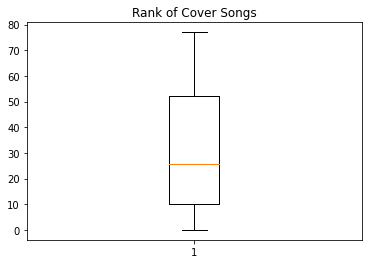

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(rank_mat)
plt.title("Rank of Cover Songs")
plt.show()

In [7]:
print(rank_mat)

[73, 50, 30, 18, 71, 12, 0, 6, 10, 21, 64, 14, 26, 4, 72, 56, 71, 17, 33, 8, 60, 69, 3, 29, 43, 34, 14, 12, 45, 19, 51, 52, 37, 3, 8, 2, 10, 45, 21, 4, 61, 34, 65, 7, 45, 52, 38, 57, 13, 57, 16, 15, 0, 34, 25, 23, 35, 10, 12, 77, 0, 6, 11, 9, 67, 62, 43, 10, 58, 45, 34, 19, 59, 70, 20, 9, 20, 10, 2, 59]
